In [1]:
from hera_cal import io
from hera_filters import dspec
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from hera_cal import frf

/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3gpu/lib/python3.8/site-packages/sklearn/utils/multiclass.py:14: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3gpu/lib/python3.8/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe2` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1
/lustre/aoc/projects/hera/aewallwi/miniconda3/envs/hera3gpu/lib/python3.8/site-packages/sklearn/utils/optimize.py:18: DeprecationWarning: Please use `line_search_wolfe1` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  from scipy.optimize.linesearch import line_search_wolfe2, line_search_wolfe1
/lustre/aoc/projects/hera/a

In [62]:
hd = io.HERAData('../MutualCouplingPaperII/paper_2_lstbinned_data.fr_model.uvh5')
data, flags, nsamples = hd.read(times=hd.times[:3500:1])
hd.write_uvh5('./data_unfiltered.uvh5', clobber=True)
hd = io.HERAData('./data_unfiltered.uvh5')
data, flags, nsamples = hd.read()

File exists; clobbering


In [63]:
xs = []
ys = []
ans = []
for an in hd.antpos:
    xs.append(hd.antpos[an][0])
    ys.append(hd.antpos[an][1])
    ans.append(an)
xs = np.array(xs)
ys = np.array(ys)
ans = np.array(ans)


invalid value encountered in true_divide


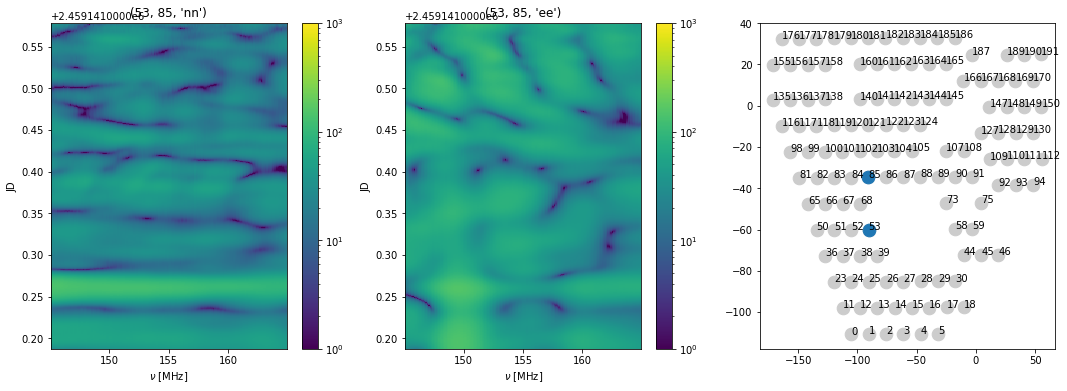

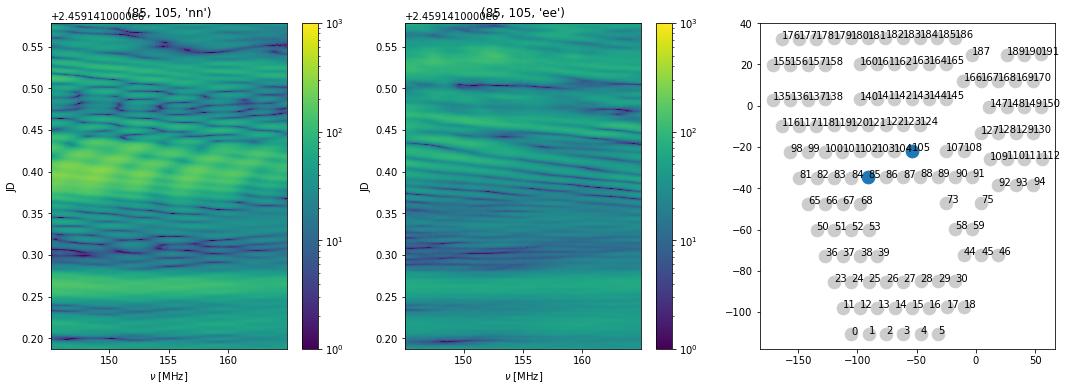

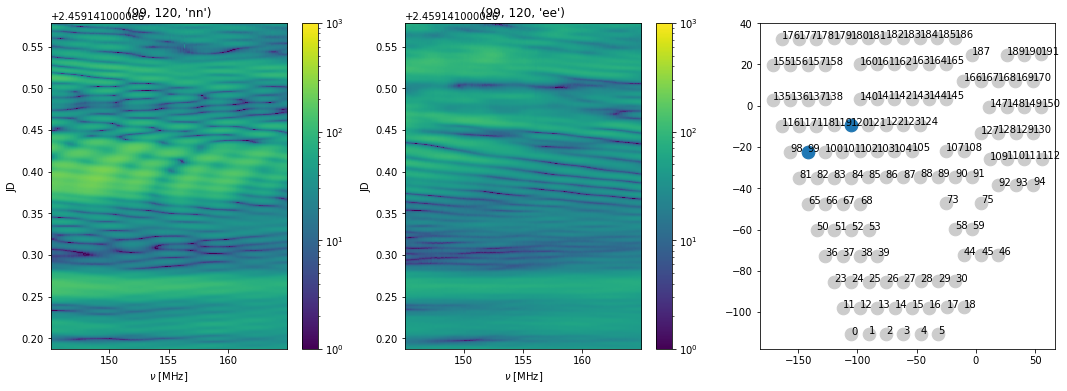

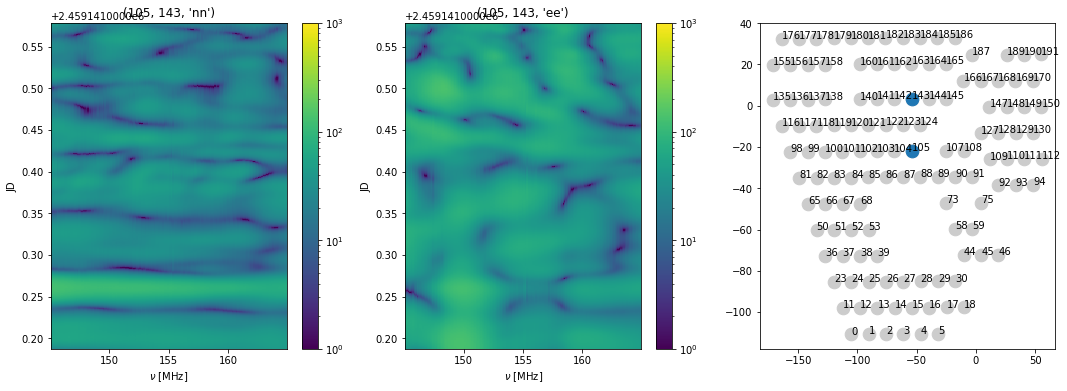

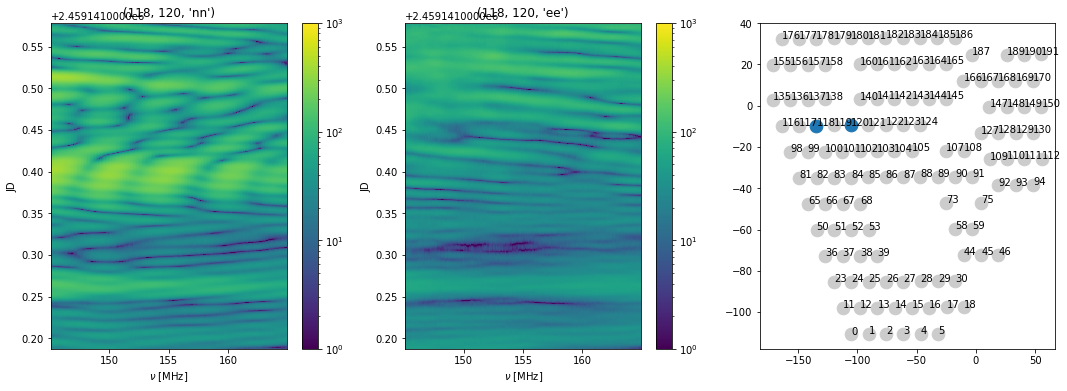

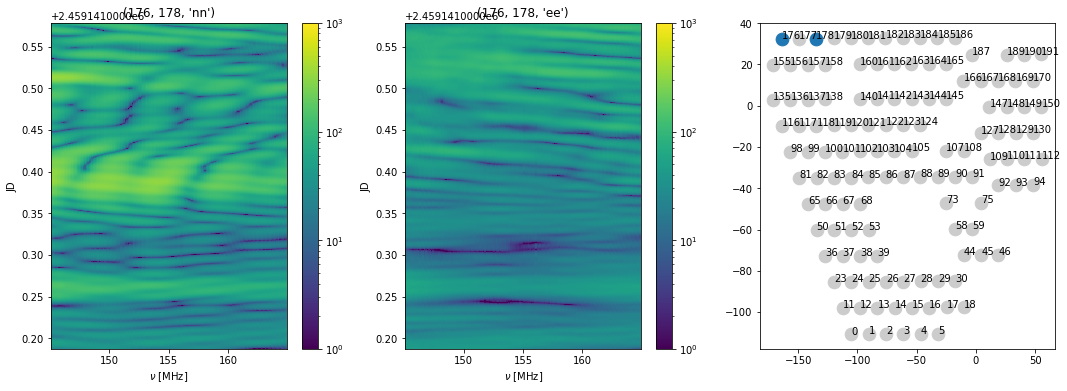

In [64]:
for ap in hd.get_antpairs():
    fig, axarr = plt.subplots(1, 3)
    plt.sca(axarr[0])
    k = ap + ('nn', )
    plt.imshow(abs(data[k]) / ~flags[k], aspect='auto', interpolation='nearest', norm=colors.LogNorm(1e0, 1e3),
              extent=[data.freqs.min()/1e6, data.freqs.max() / 1e6, hd.times.min(), hd.times.max()])
    plt.title(k)
    plt.colorbar()
    plt.xlabel('$\\nu$ [MHz]')
    plt.ylabel('JD')
    
    plt.sca(axarr[1])
    k = ap + ('ee', )
    plt.imshow(abs(data[k]) / ~flags[k], aspect='auto', interpolation='nearest', norm=colors.LogNorm(1e0, 1e3),
              extent=[data.freqs.min()/1e6, data.freqs.max() / 1e6, hd.times.min(), hd.times.max()])
    plt.title(k)
    plt.colorbar()
    plt.xlabel('$\\nu$ [MHz]')
    plt.ylabel('JD')
    
    plt.sca(axarr[2])
    plt.scatter(xs, ys, color=[.8, .8, .8], s=160)
    plt.scatter([hd.antpos[ap[0]][0], hd.antpos[ap[1]][0]],
                [hd.antpos[ap[0]][1], hd.antpos[ap[1]][1]], s=160)
    
    for x, y, n in zip(xs, ys, ans):
        plt.text(x, y, str(n))
    
    fig.set_size_inches(18, 6)

    
    plt.show()

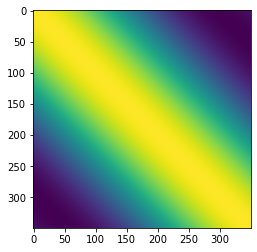

In [33]:
# Generate a since matrix for 0.025 mHz frate
SDAY_KSEC = 86164.1e-3 # ksec
times = SDAY_KSEC * (hd.times - hd.times[0])
tx, ty = np.meshgrid(times, times)
dt = tx - ty
bw = 0.025
smatrix = np.sinc(2 * bw * dt)
plt.imshow(smatrix)

evals, evecs = np.linalg.eigh(smatrix)

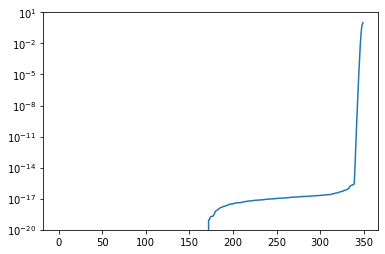

In [34]:
plt.plot(evals / evals.max())
plt.ylim(1e-20, 1e1)
plt.yscale('log')

In [35]:
selection = abs(evals / evals.max()) >= 1e-12

(0.01, 100.0)

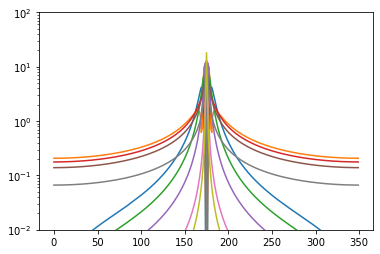

In [39]:
plt.plot(abs(np.fft.fftshift(np.fft.fft(evecs[:, selection], axis=0), axes=0)))
plt.yscale('log')
plt.ylim(1e-2, 1e2)

In [40]:
dpss_op = dspec.dpss_operator(times, [0], [0.025], eigenval_cutoff=[1e-12])[0]

In [41]:
dpss_op

array([[ 0.0239237 +0.j,  0.06654387+0.j,  0.10859314+0.j, ...,
         0.17040709+0.j,  0.18225707+0.j,  0.19196828+0.j],
       [ 0.02428041+0.j,  0.06675719+0.j,  0.10765044+0.j, ...,
         0.15741116+0.j,  0.16210445+0.j,  0.16304994+0.j],
       [ 0.02463803+0.j,  0.06696381+0.j,  0.1066968 +0.j, ...,
         0.14485683+0.j,  0.1429927 +0.j,  0.13621422+0.j],
       ...,
       [ 0.02463803+0.j, -0.06696381+0.j,  0.1066968 +0.j, ...,
        -0.14485683+0.j,  0.1429927 +0.j, -0.13621422+0.j],
       [ 0.02428041+0.j, -0.06675719+0.j,  0.10765044+0.j, ...,
        -0.15741116+0.j,  0.16210445+0.j, -0.16304994+0.j],
       [ 0.0239237 +0.j, -0.06654387+0.j,  0.10859314+0.j, ...,
        -0.17040709+0.j,  0.18225707+0.j, -0.19196828+0.j]])

(0.001, 100.0)

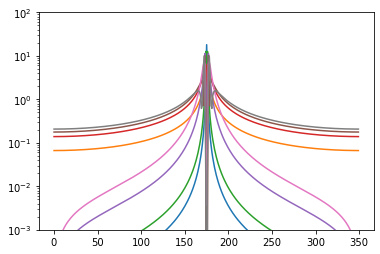

In [77]:
plt.plot(abs(np.fft.fftshift(np.fft.fft(dpss_op, axis=0), axes=0)))
plt.yscale('log')
plt.ylim(1e-3, 1e2)

In [65]:
from hera_cal import frf

frf.load_tophat_frfilter_and_write(['./data_unfiltered.uvh5'], 
                                   case="max_frate_coeffs", mode='dpss_leastsq', 
                                   max_frate_coeffs=[0.025, 0.0],
                                   res_outfilename = "./notch_filtered.uvh5", 
                                   clobber=True, skip_flagged_edges=True)

File exists; clobbering
...writing to ./notch_filtered.uvh5


In [66]:
from hera_cal import frf

frf.load_tophat_frfilter_and_write(['./data_unfiltered.uvh5'], 
                                   case="max_frate_coeffs", mode='clean', 
                                   max_frate_coeffs=[0.025, 0.0],
                                   res_outfilename = "./notch_filtered_CLEAN.uvh5", 
                                   clobber=True, skip_flagged_edges=True)

File exists; clobbering
...writing to ./notch_filtered_CLEAN.uvh5


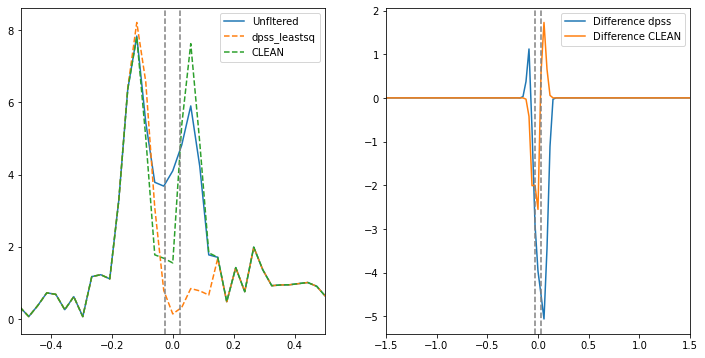

In [71]:
hd_notched = io.HERAData('./notch_filtered.uvh5')
my_frf = frf.FRFilter(hd_notched)
my_frf.read()
my_frf.fft_data(ax='time', window='bh', ifft=True)

hd_CLEAN = io.HERAData('./notch_filtered_CLEAN.uvh5')
my_frf_CLEAN = frf.FRFilter(hd_CLEAN)
my_frf_CLEAN.read()
my_frf_CLEAN.fft_data(ax='time', window='bh', ifft=True)


hd = io.HERAData('./data_unfiltered.uvh5')
my_frf_unfilt = frf.FRFilter(hd)
my_frf_unfilt.read()
my_frf_unfilt.fft_data(ax='time', window='bh', ifft=True)

fig, axarr = plt.subplots(1, 2)
plt.sca(axarr[0])
plt.plot(my_frf.frates, np.abs(my_frf_unfilt.dfft[53, 85, 'nn'][:, 50]), label='Unfltered')
plt.plot(my_frf.frates, np.abs(my_frf.dfft[53, 85, 'nn'][:, 50]), label='dpss_leastsq', ls='--')
plt.plot(my_frf.frates, np.abs(my_frf_CLEAN.dfft[53, 85, 'nn'][:, 50]), label='CLEAN', ls='--')
plt.axvline(0.025, ls='--', color='grey')
plt.axvline(-0.025, ls='--', color='grey')
plt.xlim(-.5, .5)

plt.legend()

plt.sca(axarr[1])
plt.plot(my_frf.frates, np.abs(my_frf.dfft[53, 85, 'nn'][:, 50]) - np.abs(my_frf_unfilt.dfft[53, 85, 'nn'][:, 50]),
        label='Difference dpss')
plt.plot(my_frf.frates, np.abs(my_frf_CLEAN.dfft[53, 85, 'nn'][:, 50]) - np.abs(my_frf_unfilt.dfft[53, 85, 'nn'][:, 50]),
        label='Difference CLEAN')

plt.axvline(0.025, ls='--', color='grey')
plt.axvline(-0.025, ls='--', color='grey')
plt.legend()
plt.xlim(-1.5, 1.5)
fig.set_size_inches(12, 6)
#plt.yscale('log')
#plt.ylim(1e0, 1e5)

In [74]:
my_frf.frates.max() / 1.5

34.4725671393768

In [81]:
hd = io.HERAData('./data_unfiltered.uvh5')
hd.read(times=hd.times[::34])
hd.write_uvh5('./data_unfiltered_lores.uvh5', clobber=True)
hd = io.HERAData('./data_unfiltered_lores.uvh5')
hd.read()

File exists; clobbering


(<hera_cal.datacontainer.DataContainer at 0x2ab1ce653400>,
 <hera_cal.datacontainer.DataContainer at 0x2ab1d36daa30>)

(0.001, 100.0)

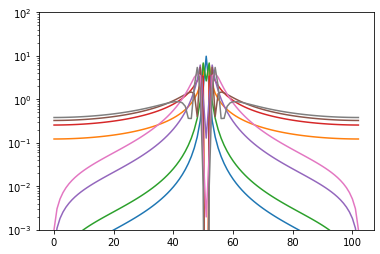

In [82]:
dpss_op = dspec.dpss_operator(hd.times * SDAY_KSEC, [0], [0.025], eigenval_cutoff=[1e-12])[0]
plt.plot(abs(np.fft.fftshift(np.fft.fft(dpss_op, axis=0), axes=0)))
plt.yscale('log')
plt.ylim(1e-3, 1e2)

In [83]:
from hera_cal import frf

frf.load_tophat_frfilter_and_write(['./data_unfiltered_lores.uvh5'], 
                                   case="max_frate_coeffs", mode='dpss_leastsq', 
                                   max_frate_coeffs=[0.025, 0.0],
                                   res_outfilename = "./notch_filtered_lores.uvh5", 
                                   clobber=True, skip_flagged_edges=True)

...writing to ./notch_filtered_lores.uvh5


In [84]:
from hera_cal import frf

frf.load_tophat_frfilter_and_write(['./data_unfiltered_lores.uvh5'], 
                                   case="max_frate_coeffs", mode='clean', 
                                   max_frate_coeffs=[0.025, 0.0],
                                   res_outfilename = "./notch_filtered_CLEAN_lores.uvh5", 
                                   clobber=True, skip_flagged_edges=True)

...writing to ./notch_filtered_CLEAN_lores.uvh5


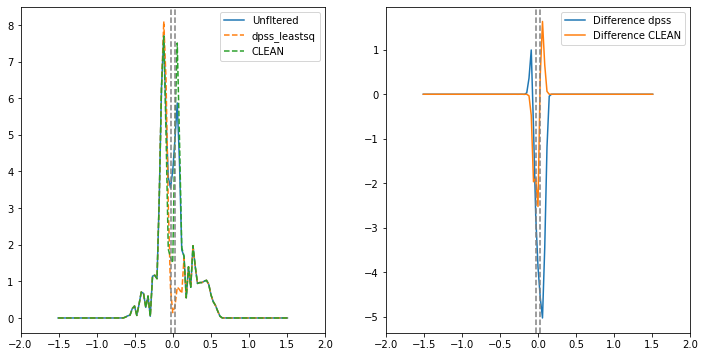

In [86]:
hd_notched = io.HERAData('./notch_filtered_lores.uvh5')
my_frf = frf.FRFilter(hd_notched)
my_frf.read()
my_frf.fft_data(ax='time', window='bh', ifft=True)

hd_CLEAN = io.HERAData('./notch_filtered_CLEAN_lores.uvh5')
my_frf_CLEAN = frf.FRFilter(hd_CLEAN)
my_frf_CLEAN.read()
my_frf_CLEAN.fft_data(ax='time', window='bh', ifft=True)


hd = io.HERAData('./data_unfiltered_lores.uvh5')
my_frf_unfilt = frf.FRFilter(hd)
my_frf_unfilt.read()
my_frf_unfilt.fft_data(ax='time', window='bh', ifft=True)

fig, axarr = plt.subplots(1, 2)
plt.sca(axarr[0])
plt.plot(my_frf.frates, np.abs(my_frf_unfilt.dfft[53, 85, 'nn'][:, 50]), label='Unfltered')
plt.plot(my_frf.frates, np.abs(my_frf.dfft[53, 85, 'nn'][:, 50]), label='dpss_leastsq', ls='--')
plt.plot(my_frf.frates, np.abs(my_frf_CLEAN.dfft[53, 85, 'nn'][:, 50]), label='CLEAN', ls='--')
plt.axvline(0.025, ls='--', color='grey')
plt.axvline(-0.025, ls='--', color='grey')
plt.xlim(-2, 2)

plt.legend()

plt.sca(axarr[1])
plt.plot(my_frf.frates, np.abs(my_frf.dfft[53, 85, 'nn'][:, 50]) - np.abs(my_frf_unfilt.dfft[53, 85, 'nn'][:, 50]),
        label='Difference dpss')
plt.plot(my_frf.frates, np.abs(my_frf_CLEAN.dfft[53, 85, 'nn'][:, 50]) - np.abs(my_frf_unfilt.dfft[53, 85, 'nn'][:, 50]),
        label='Difference CLEAN')

plt.axvline(0.025, ls='--', color='grey')
plt.axvline(-0.025, ls='--', color='grey')
plt.legend()
plt.xlim(-2, 2)
fig.set_size_inches(12, 6)
#plt.yscale('log')
#plt.ylim(1e0, 1e5)